# TV shows Popularity Predictor (39%)

The goal of this challenge is to create a model that predicts the `popularity` of a movie or TV show

<img src="image.jpg" width=300 />




The dataset contains a list of movies and TV shows with the following characteristics:
- `title`: title of the movie in english
- `original_title`: original title of the movie 
- `duration_min`: duration of the movie in minutes
- `popularity`: popularity of the movie in terms of review scores
- `release_date`: release date
- `description`: short summary of the movie
- `budget`: budget spent to produce the movie in USD
- `revenue`: movie revenue in USD 
- `original_language`: original language 
- `status`: is the movie already released or not
- `number_of_awards_won`: number of awards won for the movie
- `number_of_nominations`: number of nominations
- `has_collection`: if the movie is part of a sequel or not
- `all_genres`: genres that described the movie (can be zero, one or many!) 
- `top_countries`: countries where the movie was produced (can be zero, one or many!) 
- `number_of_top_productions`: number of top production companies that produced the film if any. 
Top production companies includes: Warner Bros, Universal Pictures, Paramount Pictures, Canal+, etc...
- `available_in_english`: whether the movie is available in english or not

## Imports

Run the following cell to load the basic packages:

In [1]:
!pip install nbresult

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nbresult import ChallengeResult

## Data collection

📝 **Load the `movie_popularity.csv` dataset from the provided this [URL](https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/tv_movies_popularity.csv)**
- First, check and remove the rows that may be complete duplicate from one another (we never know!)
- Then, drop the columns that have too much missing values
- Finally, drop the few remaining rows that have missing values
- Store the result in a `DataFrame` named `data`

In [3]:
# YOUR CODE HERE
data_original = pd.read_csv('https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/tv_movies_popularity.csv')

# Si l'url ne marche plus
# data_ original = pd.read_csv('tv_movies_popularity.csv')

data = data_original.copy()
data.shape

(6864, 17)

In [4]:
# First, check and remove the rows that may be complete duplicate from one another (we never know!)
duplicate_count = data.duplicated().sum()
duplicate_count

400

In [5]:
data = data.drop_duplicates()
data.shape

(6464, 17)

In [6]:
# Then, drop the columns that have too much missing values
round(data.isna().sum().sort_values(ascending = False)/len(data),3)
# De toute evidence, il y a trop de missing value dans revenue

revenue                      0.595
title                        0.000
available_in_english         0.000
popularity                   0.000
release_date                 0.000
duration_min                 0.000
description                  0.000
budget                       0.000
original_language            0.000
number_of_top_productions    0.000
status                       0.000
number_of_awards_won         0.000
number_of_nominations        0.000
has_collection               0.000
all_genres                   0.000
top_countries                0.000
original_title               0.000
dtype: float64

In [7]:
data.head()

,original_title,title,popularity,release_date,duration_min,description,budget,revenue,original_language,status,number_of_awards_won,number_of_nominations,has_collection,all_genres,top_countries,number_of_top_productions,available_in_english
0,Hot Tub Time Machine 2,Hot Tub Time Machine 2,6.575393,2015-02-20,93.0,"When Lou's shot in the groin, Nick and Jacob d...",14000000,12314651.0,en,Released,0,2,1,Comedy,United States of America,3,True
1,The Princess Diaries 2: Royal Engagement,The Princess Diaries 2: Royal Engagement,8.248895,2004-08-06,113.0,"Now settled in Genovia, Princess Mia faces a n...",40000000,95149435.0,en,Released,1,2,1,"Comedy, Drama, Family, Romance",United States of America,1,True
2,Whiplash,Whiplash,64.299990,2014-10-10,105.0,A promising young drummer enrolls at a cut-thr...,3300000,13092000.0,en,Released,97,145,0,Drama,United States of America,0,True
3,Kahaani,Kahaani,3.174936,2012-03-09,122.0,A pregnant woman's search for her missing husb...,1200000,16000000.0,hi,Released,23,18,0,"Drama, Thriller",India,0,True
4,The Possession,The Possession,7.286477,2012-08-30,92.0,A young girl buys an antique box at a yard sal...,14000000,85446075.0,en,Released,0,6,0,"Horror, Thriller","Canada, United States of America",0,True


In [8]:
data = data.drop(['revenue'],axis=1)


In [9]:
data.shape

(6464, 16)

In [10]:
# Finally, drop the few remaining rows that have missing values

null_data = data[data.isnull().any(axis=1)]
null_data
# La seul ligne ayant encore des valeurs manquante est celle d'index 5783

,original_title,title,popularity,release_date,duration_min,description,budget,original_language,status,number_of_awards_won,number_of_nominations,has_collection,all_genres,top_countries,number_of_top_productions,available_in_english
5783,Barefoot,NaN,5.939334,2014-02-02,90.0,"The ""black sheep"" son of a wealthy family meet...",6000000,en,Released,0,1,0,"Comedy, Drama, Romance",other countries,0,False


In [11]:
data = data.drop([5783],axis=0)

In [12]:
data.shape

(6463, 16)

### 🧪 Run the following cell to save your results

In [13]:
from nbresult import ChallengeResult

result = ChallengeResult(
    "data_cleaning",
    columns=data.columns,
    cleaning=sum(data.isnull().sum()),
    shape=data.shape)
result.write()

## Baseline model

### The metric

📝 **We want to predict `popularity`: Start by plotting a histogram of the target to visualize it**

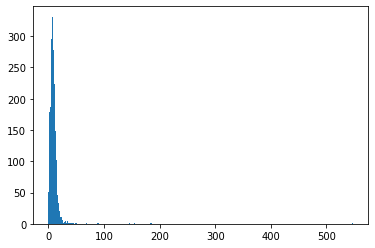

In [14]:
plt.hist(data['popularity'], bins = 1000);
# La majeur partie des popularité semble être situé entre 0 et 50. On va créer un deu

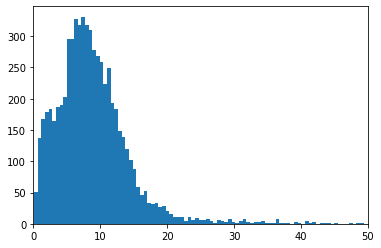

In [15]:
# La majeur partie des popularité semble être situé entre 0 et 50. On va créer un deuxième histogramme pour regarder plus précisement
plt.hist(data['popularity'], bins = 1000)
plt.xlim(0,50);

📝 **Which sklearn's scoring [metric](https://scikit-learn.org/stable/modules/model_evaluation.html) should we use if we want it to:**

- Be better when greater (i.e. metric_good_model > metric_bad_model)
- Penalize **more** an error between 10 and 20 compared with an error between 110 and 120
- Said otherwise, what matter should be the **relative error ratio**, more than the absolute error difference

Hint: the histogram plotted above should give you some intuition about it

👉 Store its exact [sklearn scoring name](https://scikit-learn.org/stable/modules/model_evaluation.html) as `string` in the variable `scoring` below.

🚨 You must use this metric for the rest of the challenge

In [16]:
# YOUR CODE HERE
scoring = 'neg_mean_absolute_percentage_error'

<details>
    <summary>💡 Hint</summary>
It is around here!
<img src="scores.jpg" width=200 height=400 />
</details>

### X,y

**📝 Define `X` as the features Dataframe (keep all features) and `y` as the target Series.**

In [17]:
# YOUR CODE HERE
X = data.drop(['popularity'],axis=1)
y = data['popularity']

### Basic pipeline

📝 **Check unique values per features**

In [18]:
# YOUR CODE HERE
data.nunique()

original_title               6350
title                        6337
popularity                   6462
release_date                 4320
duration_min                  152
description                  6449
budget                        636
original_language              42
status                          3
number_of_awards_won          124
number_of_nominations         180
has_collection                  2
all_genres                    745
top_countries                 320
number_of_top_productions       5
available_in_english            2
dtype: int64

In this baseline, let's forget about the columns below that are difficult to process

In [19]:
text = ['description', 'original_title', 'title']
dates = ['release_date'] 

We will simply scale the numerical features and one-hot-encode the categorical ones remaining

📝 **Prepare 2 `list`s of features names as `str`**:
- `numerical` which contains **only** numerical features
- `categorical` which contains **only** categorical features (exept text and dates above)

In [20]:
# YOUR CODE HERE
numerical = ['duration_min','budget','number_of_awards_won','number_of_nominations','number_of_top_productions']
categorical = ['original_language','status','has_collection','all_genres','top_countries','available_in_english']

### Pipelining

You are going to build a basic pipeline made of a basic preprocessing and a trees-based model of your choice.

#### Preprocessing pipeline

**📝 Create a basic preprocessing pipeline for the 2 types of features above:**
- It should scale the `numerical` features
- one-hot-encode the `categorical` and `boolean` features
- drop the others
- Store your pipeline in a `basic_preprocessing` variable

In [21]:
!pip install --upgrade scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.7/dist-packages (0.24.2)


In [22]:
# Execute this cell to enable a nice display for your pipelines
from sklearn import set_config; set_config(display='diagram')

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer

In [24]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

In [25]:
# YOUR CODE HERE
basic_preprocessing = ColumnTransformer([
    ('cat',OneHotEncoder(sparse = False,handle_unknown='ignore'),categorical),
    ('num',MinMaxScaler(),numerical)
])
basic_preprocessing

ColumnTransformer(transformers=[('cat',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 ['original_language', 'status',
                                  'has_collection', 'all_genres',
                                  'top_countries', 'available_in_english']),
                                ('num', MinMaxScaler(),
                                 ['duration_min', 'budget',
                                  'number_of_awards_won',
                                  'number_of_nominations',
                                  'number_of_top_productions'])])

**📝 Encode the features and store the result in the variable `X_basic_preprocessing`.**

In [26]:
# YOUR CODE HERE
X_basic_preprocessing = basic_preprocessing.fit_transform(X)

In [27]:
X_basic_preprocessing.shape

(6463, 1119)

**❓ How many features has been generated by the preprocessing? What do you think about this number?**

> YOUR ANSWER HERE

On a obtenu 1119 features. Ceci est sans doute due au One Hot Encoder et aux colonnes All_Genre et Top_Country qui possède beaucoup de catégorie, même si en réalité, il s'agit plutot de plusieurs categorie en même temps, que notre modèle de base ne peux pas identifier correctement.

#### Modeling pipeline

Let's add a model to our pipe. With so many features one-hot-encoded, we **need a model which can act as a feature selector**

👉 A linear model regularized with L1 penalty is a good starting point.


**📝 Create a `basic_pipeline` which encapsulate the `basic_preprocessing` pipeline + a linear model with a L1 penalty**

- store the resulting pipeline as `basic_pipeline`
- don't fine-tune it


<details>
    <summary>Hints</summary>

Choose your model from the list [here](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model)

</details>

In [28]:
# On importe le modele 
from sklearn.linear_model import Lasso

In [29]:
# YOUR CODE HERE
basic_pipeline = Pipeline([
    ('scaler', basic_preprocessing),
    ('model',Lasso() )
    ])
    

### Cross-validated baseline

**📝 Perform a cross-validated evaluation of your baseline model using the metric you defined above. Store the results of this evaluation as an `array` of floating scores in the `basic_scores` variable.**

In [30]:
# YOUR CODE HERE
from sklearn.model_selection import cross_validate

basic_pipeline.fit(X,y)

cv_results = cross_validate(basic_pipeline,X,y,cv=5,scoring = scoring)
basic_scores = cv_results['test_score']
basic_scores

array([-1.04544119, -1.16014631, -1.16193529, -1.15331708, -1.13883244])

### 🧪 Save your results

Run the following cell to save your results

In [31]:
ChallengeResult(
    'baseline',
    metric=scoring,
    features=[categorical,numerical],
    preproc=basic_preprocessing,
    preproc_shape=X_basic_preprocessing.shape,
    pipe=basic_pipeline,
    scores=basic_scores
).write()

## Feature engineering

### Time Features


👉 Let's try to improve performance using the feature `release_date`, and especially its `month` and `year`.

ℹ️ If you want to skip this section, you can move directly to the next one: _Advanced categorical features_.

**📝 Complete the custom transformer `TimeFeaturesExtractor` below**

Running
```python
TimeFeaturesExtractor().fit_transform(X[['release_date']])
``` 
should return something like

|    |   month |   year |
|---:|--------:|-------:|
|  0 |       2 |   2015 |
|  1 |       8 |   2004 |
|  2 |      10 |   2014 |
|  3 |       3 |   2012 |
|  4 |       8 |   2012 |


In [32]:
from sklearn.base import BaseEstimator, TransformerMixin

class TimeFeaturesExtractor(BaseEstimator, TransformerMixin):
    """Extract the 2 time features from a date"""
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        """
        Params:
        X: DataFrame
        y: Series
        
        Returns a DataFrame with 2 columns containing the time features as integers extracted from the release_date.
        """
        pass  # YOUR CODE HERE

In [33]:
# Try your transformer and save your new features here
#X_time_features = TimeFeaturesExtractor().fit_transform(X[['release_date']])
#X_time_features.head()

We still have 2 problems to solve
- `month` is cyclical: 12 should be a close to 1 as to 11, right? 
- `year` is not scaled

**📝 Build a final custom transformer `CyclicalEncoder` so that**

Running
```python
CyclicalEncoder().fit_transform(X_time_features)
``` 
should return something like this

|    |    month_cos |   month_sin |      year |
|---:|-------------:|------------:|----------:|
|  0 |  0.5         |    0.866025 | 0.0466039 |
|  1 | -0.5         |   -0.866025 | 0.0411502 |
|  2 |  0.5         |   -0.866025 | 0.0461081 |
|  3 |  6.12323e-17 |    1        | 0.0451165 |
|  4 | -0.5         |   -0.866025 | 0.0451165 |

With the cyclical encoding is done as below
- `month_cos = 2 * math.pi / 12 * X[['month']] `
- `month_sin = 2 * math.pi / 12 * X[['month']] `

And the `year` begin min-max scaled

In [34]:
from sklearn.base import BaseEstimator, TransformerMixin
import math

class CyclicalEncoder(BaseEstimator, TransformerMixin):
    """
    Encode a cyclical feature
    """
    
    def __init__(self):
        pass

    def fit(self, X, y=None):
        """
        Compute here what you need for the transform phase and store it as instance variable
        """
        pass  # YOUR CODE HERE

    def transform(self, X, y=None):
        """
        Compute and returns the final DataFrame
        """
        pass  # YOUR CODE HERE

In [35]:
# Try your transformer and save your new features here
#X_time_cyclical = CyclicalEncoder().fit_transform(X_time_features)
#X_time_cyclical.head()

In [36]:
# Check that this form a circle with 12 points
#plt.scatter(X_time_cyclical['month_cos'],
#            X_time_cyclical['month_sin'])
#plt.xlabel("month_cos"); plt.ylabel("month_sin");

**📝 Enhance your `basic_pipeline` with a new preprocessing including both `TimeFeaturesExtractor` and `CyclicalFeatureExtractor`:**

- Just use `TimeFeatureExtractor` if you haven't had time to do the `Cyclical` one
- Store this new pipeline as `time_pipeline`
- Keep same estimator for now

In [37]:
# YOUR CODE HERE

### Advanced categorical encoder to reduce the number of features

ℹ️ Most of it has already been coded for you and it shouldn't take long. Still if you want to skip it and move to the next section: _Model Tuning_

👉 We need to reduce the number of features to one-hot-encode, which arise from the high cardinality of `all_genres` and `top_countries`

In [38]:
X[['all_genres', 'top_countries']].nunique()

all_genres       745
top_countries    320
dtype: int64

👇 Both share a common pattern: there can be more than 1 country and more than 1 genre per movie.

In [39]:
X[['all_genres', 'top_countries']].tail()

,all_genres,top_countries
6459,Thriller,"France, United States of America"
6460,"Action, Adventure, Comedy, Thriller",United States of America
6461,Drama,United States of America
6462,"Horror, Thriller",United States of America
6463,Drama,France


👉 Run the cell below where we have coded for you a custom transformer `CustomGenreAndCountryEncoder` which: 
- Select the 10 most frequent genres and the 5 most frequent countries
- Encode `all_genres` into 10 One Hot Encoded features
- Encode `top_countries` into 5 One Hot Encoded features

In [40]:
from collections import Counter
from sklearn.base import BaseEstimator, TransformerMixin

class CustomGenreAndCountryEncoder(BaseEstimator, TransformerMixin):
    """
    Encoding the all_genres and top_companies features which are multi-categorical :
    a movie has several possible genres and countries of productions!
    """

    def __init__(self):
        pass

    def fit(self, X, y=None):
        """
        compute top genres and top countries of productions from all_genres and top_countries features
        """

        # compute top 10 genres       
        list_of_genres = list(X['all_genres'].apply(lambda x: [i.strip() for i in x.split(",")] if x != [''] else []).values)
        top_genres = [m[0] for m in Counter([i for j in list_of_genres for i in j]).most_common(10)]

        # save top_genres in dedicated instance variable
        self.top_genres = top_genres
        
         # compute top 5 countries       
        list_of_countries = list(X['top_countries'].apply(lambda x: [i.strip() for i in x.split(",")] if x != [''] else []).values)
        top_countries = [m[0] for m in Counter([i for j in list_of_countries for i in j]).most_common(5)]

        # save top_countries in dedicated instance variable
        self.top_countries = top_countries

        return self

    def transform(self, X, y=None):
        """
        encoding genre and country
        """
        X_new = X.copy()
        for genre in self.top_genres:
            X_new['genre_' + genre] = X_new['all_genres'].apply(lambda x: 1 if genre in x else 0)
        X_new = X_new.drop(columns=["all_genres"])
        for country in self.top_countries:
            X_new['country_' + country] = X_new['top_countries'].apply(lambda x: 1 if country in x else 0)
        X_new = X_new.drop(columns=["top_countries"])
        return X_new

In [41]:
# Check it out
X_custom = CustomGenreAndCountryEncoder().fit_transform(X[['all_genres', 'top_countries']])
print(X_custom.shape)
X_custom.head()

(6463, 15)


,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Adventure,genre_Crime,genre_Science Fiction,genre_Horror,genre_Family,country_United States of America,country_United Kingdom,country_France,country_Germany,country_Canada
0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
1,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1


**📝 Compute your `final_pipeline` by integrating all these transformers** (or all those you have coded)

- `CustomGenreAndCountryEncoder`
- `TimeFeaturesExtractor`
- `CyclicalFeatureExtractor`

In [42]:
from sklearn.compose import make_column_selector

In [43]:
# On crée une nouvelle selection de categorie pour le One Hot Encoder

new_categorical = ['original_language','status','has_collection','available_in_english'] 


In [44]:

# On ajoute les nouveaux preprocessing (Time et Cyclical n'ont pas été fait par manque de temps)
new_preprocessing = ColumnTransformer([
    ('num',MinMaxScaler(),numerical),
    ('genre_country',CustomGenreAndCountryEncoder(),['all_genres', 'top_countries']),
    ('cat',OneHotEncoder(sparse = False,handle_unknown='ignore'),new_categorical)

])

In [45]:
final_pipeline = Pipeline([
    ('scaler', new_preprocessing),
    ('model',Lasso() )
    ])

📝 **Compute and store its cross validated scores as `final_scores` array of floats**

- It does not necessarily improve the performance before we can try-out doing model tuning
- However, with a now limited number of features, we will be able to train more complex models in next section (ensemble...)

In [46]:
final_pipeline.fit(X,y)

cv_results_final = cross_validate(final_pipeline,X,y,cv=5,scoring = scoring)
final_scores = cv_results_final['test_score']
final_scores

array([-1.04544119, -1.16014631, -1.16193529, -1.15331708, -1.13883244])

In [47]:
X_time_features = 'Non effectué'
X_time_cyclical = 'Non effectué'
time_pipeline = 'Non effectué'

### 🧪 Save your result

Run the following cell to save your results.

In [48]:
ChallengeResult(
    'feature_engineering',
    X_time_features=X_time_features,
    X_time_cyclical= X_time_cyclical,
    time_pipeline=time_pipeline,
    final_pipeline=final_pipeline,
    final_scores=final_scores
).write()

# Hint: Try restarting your notebook if you obtain an error about saving a custom encoder

## Model tuning

### Random Forest

📝 **Change the estimator of your `final_pipeline` by a Random Forest and checkout your new cross-validated score**

In [49]:
from sklearn.ensemble import RandomForestRegressor

In [50]:
# YOUR CODE HERE
forest_pipeline = Pipeline([
    ('scaler', new_preprocessing),
    ('model',RandomForestRegressor(n_estimators=100))
    ])

In [51]:
forest_pipeline.fit(X,y)

cv_results_forest = cross_validate(forest_pipeline,X,y,cv=5,scoring = scoring)
forest_scores = cv_results_forest['test_score']
forest_scores

array([-0.72507812, -0.83205978, -0.77328668, -0.74879764, -0.70973287])

### Best hyperparameters quest



**📝 Fine tune your model to try to get the best performance in the minimum amount of time!**

- Store the result of your search inside the `search` variable.
- Store your 5 cross-validated scores inside `best_scores` array of floats

In [52]:
# YOUR CODE HERE
from sklearn.model_selection import GridSearchCV

In [53]:
forest_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'scaler', 'model', 'scaler__n_jobs', 'scaler__remainder', 'scaler__sparse_threshold', 'scaler__transformer_weights', 'scaler__transformers', 'scaler__verbose', 'scaler__num', 'scaler__genre_country', 'scaler__cat', 'scaler__num__clip', 'scaler__num__copy', 'scaler__num__feature_range', 'scaler__cat__categories', 'scaler__cat__drop', 'scaler__cat__dtype', 'scaler__cat__handle_unknown', 'scaler__cat__sparse', 'model__bootstrap', 'model__ccp_alpha', 'model__criterion', 'model__max_depth', 'model__max_features', 'model__max_leaf_nodes', 'model__max_samples', 'model__min_impurity_decrease', 'model__min_impurity_split', 'model__min_samples_leaf', 'model__min_samples_split', 'model__min_weight_fraction_leaf', 'model__n_estimators', 'model__n_jobs', 'model__oob_score', 'model__random_state', 'model__verbose', 'model__warm_start'])

In [54]:
X_short = X[:100]
y_short = y[:100]

In [55]:

grid = {'model__criterion':['mse','mae'],'model__max_features':['auto', 'sqrt', 'log2'],'model__n_estimators':[10,100]}

search = GridSearchCV(forest_pipeline,
                      grid,
                      cv=5,
                      scoring = scoring,
                      n_jobs=-1)

search.fit(X_short,y_short)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['duration_min',
                                                                          'budget',
                                                                          'number_of_awards_won',
                                                                          'number_of_nominations',
                                                                          'number_of_top_productions']),
                                                                        ('genre_country',
                                                                         CustomGenreAndCountryEncoder(),
                                                                         ['all_genres',
                                                                          'top_countries']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         ['original_language',
                                                                          'status',
                                                                          'has_collection',
                                                                          'available_in_english'])])),
                                       ('model', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'model__criterion': ['mse', 'mae'],
                         'model__max_features': ['auto', 'sqrt', 'log2'],
                         'model__n_estimators': [10, 100]},
             scoring='neg_mean_absolute_percentage_error')

In [56]:
search.best_estimator_

Pipeline(steps=[('scaler',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['duration_min', 'budget',
                                                   'number_of_awards_won',
                                                   'number_of_nominations',
                                                   'number_of_top_productions']),
                                                 ('genre_country',
                                                  CustomGenreAndCountryEncoder(),
                                                  ['all_genres',
                                                   'top_countries']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['original_language',
                                                   'status', 'has_collection',
                                                   'available_in_english'])])),
                ('model',
                 RandomForestRegressor(max_features='log2', n_estimators=10))])

**📝 Re-train your best pipeline on the whole (X,y) dataset**
- Store the trained pipeline inside the `best_pipeline` variable

In [57]:
# YOUR CODE HERE
best_pipeline = search.best_estimator_.fit(X,y)

In [58]:
cv_results_best = cross_validate(best_pipeline,X,y,cv=5,scoring = scoring)
best_scores = cv_results_best['test_score']
best_scores

array([-0.71634454, -0.78561241, -0.81104597, -0.76049136, -0.70199475])

### Prediction

Now you have your model tuned with the best hyperparameters, you are ready for a prediction.

Here is a famous TV show released in 2017:

```python
dict(
        original_title=str("La Casa de Papel"),
        title=str("Money Heist"), 
        release_date= pd.to_datetime(["2017-05-02"]), 
        duration_min=float(50),
        description=str("An unusual group of robbers attempt to carry out the most perfect robbery"), 
        budget=float(3_000_000), 
        original_language =str("es"), 
        status=str("Released"),
        number_of_awards_won =int(2), 
        number_of_nominations=int(5), 
        has_collection=int(1),
        all_genres=str("Action, Crime, Mystery"), 
        top_countries=str("Spain, France, United States of America"), 
        number_of_top_productions=int('1'),
        available_in_english=bool('True') 
)
```

**📝 Compute the predicted popularity of this TV show and store it into the `popularity` variable as a floating number.**

In [59]:
to_predict = dict(
        original_title=str("La Casa de Papel"),
        title=str("Money Heist"), 
        release_date= pd.to_datetime(["2017-05-02"]), 
        duration_min=float(50),
        description=str("An unusual group of robbers attempt to carry out the most perfect robbery"), 
        budget=float(3_000_000), 
        original_language =str("es"), 
        status=str("Released"),
        number_of_awards_won =int(2), 
        number_of_nominations=int(5), 
        has_collection=int(1),
        all_genres=str("Action, Crime, Mystery"), 
        top_countries=str("Spain, France, United States of America"), 
        number_of_top_productions=int('1'),
        available_in_english=bool('True') 
)

In [60]:
pd.DataFrame(to_predict)

,original_title,title,release_date,duration_min,description,budget,original_language,status,number_of_awards_won,number_of_nominations,has_collection,all_genres,top_countries,number_of_top_productions,available_in_english
0,La Casa de Papel,Money Heist,2017-05-02,50.0,An unusual group of robbers attempt to carry o...,3000000.0,es,Released,2,5,1,"Action, Crime, Mystery","Spain, France, United States of America",1,True


In [61]:
# YOUR CODE HERE
popularity = best_pipeline.predict(pd.DataFrame(to_predict))

In [62]:
popularity

array([12.0903408])

In [63]:
# YOUR CODE HERE

### 🧪 Save your results

Run the following cell to save your results.

In [64]:
ChallengeResult(
    "model_tuning",
    search=search,
    best_pipeline=best_pipeline,
    best_scores = best_scores,
    popularity=popularity
).write()

## API 

Time to put a pipeline in production!

👉 Go to https://github.com/lewagon/data-certification-api and follow instructions

**This final part is independent from the above notebook**